### Embedding comparison
In this notebook, we visualize the different embeddings achieved by each model

In [1]:
import pandas as pd
import numpy as np

import tensorflow
from tensorflow.keras import optimizers, losses, activations, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, Dropout, GRU, \
    concatenate, Add, Activation
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_recall_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
from IPython.display import Image

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
import sklearn.decomposition as decomposition

### Models to be loaded and layer to extract the embeddings from

In [11]:
models = {'baseline' : 'baseline/baseline_cnn',
          'deep_res' : 'deep_res/cnn_res_deep',
          'paper'    : 'paper/cnn_paper',
          'rnn'      : 'rnn/rnn'}
models_embedding_layer = {'baseline': 15,
                          'deep_res': 89,
                          'paper'   : 29,
                          'rnn'     : 3}

In [3]:
df_train = pd.read_csv("data/mitbih_train.csv", header=None)
df_train = df_train.sample(frac=1)
df_test = pd.read_csv("data/mitbih_test.csv", header=None)

Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

In [4]:
df_1 = pd.read_csv("data/ptbdb_normal.csv", header=None)
df_2 = pd.read_csv("data/ptbdb_abnormal.csv", header=None)
df = pd.concat([df_1, df_2])

df_train, df_test = train_test_split(df, test_size=0.2, random_state=1337, stratify=df[187])

Y_pt = np.array(df_train[187].values).astype(np.int8)
X_pt = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test_pt = np.array(df_test[187].values).astype(np.int8)
X_test_pt = np.array(df_test[list(range(187))].values)[..., np.newaxis]

### Extract embeddings, use pca to reduce dimensionality, use t-sne to project to 2D
Might take a few minutes. Each run will use a different random subset.

We find the embeddings from the deep network especially aesthetic.

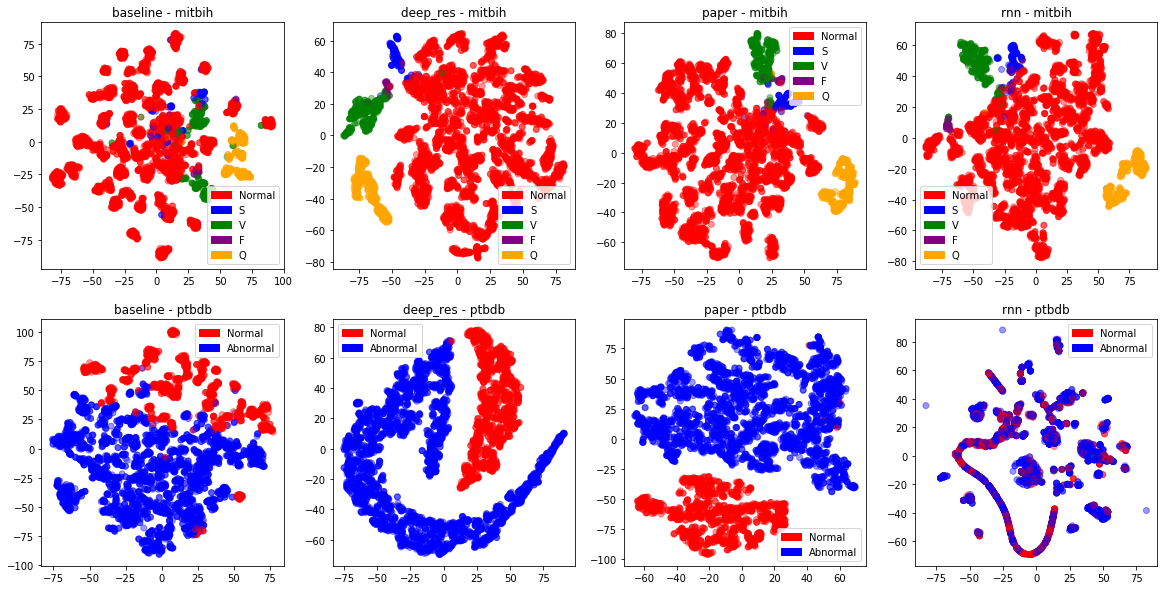

In [12]:
subset_size = 5000
subsets = {'mitbih' : np.random.randint(X.shape[0], size=(subset_size)),
           'ptbdb'  : np.random.randint(X_pt.shape[0], size=(subset_size)) }
datasets = {'mitbih' : (X, Y),
            'ptbdb'  : (X_pt, Y_pt)}
fig,a = plt.subplots(2, len(models))
fig.set_figheight(10)
fig.set_figwidth(20)


for col, task in enumerate(['mitbih', 'ptbdb']):
    for row, (name, path) in enumerate(models.items()):
        if task is 'ptbdb':
            colors = ['r', 'b']
            label_names = ['Normal', 'Abnormal']
        else:
            colors = ['r', 'b', 'g', 'purple', 'orange']
            label_names = ['Normal', 'S', 'V', 'F', 'Q']
        colors_artists = [mpatches.Patch(color=colors[i], label=label_names[i]) for i in range(len(colors))]
        
        cur_model = load_model(path + '_' + task + '.h5')
        final_layer = models_embedding_layer[name]
        if name is 'rnn' and task is 'ptbdb':
            final_layer -= 1
        
        embeding_model = Model(inputs=cur_model.inputs, outputs=cur_model.layers[final_layer].output) # get embeddings from last conv layer
        embedings = embeding_model.predict(datasets[task][0][subsets[task]])
        
        X_centered = embedings - embedings.mean(axis=0)
        pca = decomposition.PCA(n_components=50)
        embedings_reduced = pca.fit_transform(X_centered)
        
        t_sne = TSNE(n_components=2).fit_transform(embedings_reduced)
        
        a[col][row].scatter([t_sne[i, 0] for i in range(subset_size)], [t_sne[i, 1] for i in range(subset_size)],
                 c=[colors[datasets[task][1][subsets[task][i]]] for i in range(subset_size)], label=[datasets[task][1][subsets[task][i]] for i in range(subset_size)], alpha=0.4)
        a[col][row].legend(handles=colors_artists)
        a[col][row].set_title(name + " - " + task)